In [ ]:
# %%capture
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bibekchalise","key":"53b5557999a6db293e648ba8d77affc6"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

 90% 217M/242M [00:03<00:00, 85.7MB/s]
100% 242M/242M [00:03<00:00, 76.2MB/s]


In [ ]:
!ls

5-flower-types-classification-dataset.zip  kaggle.json	sample_data


In [ ]:
%%capture
!unzip 5-flower-types-classification-dataset.zip

In [ ]:
data_dir = '/content/flower_images'

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import glob, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch.nn as nn
!pip install torch_summary
from torchvision import transforms, models, datasets
from torch.optim import Adam, SGD
import  torch.nn.functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
path = glob.glob(data_dir+'/*/*')

In [ ]:
df = pd.DataFrame(path, columns=['path'])

In [ ]:
df['label'] = df['path'].apply(lambda x: x.split('/')[-2])

In [ ]:
df

,path,label
0,/content/flower_images/Orchid/e67e5ee3ef.jpg,Orchid
1,/content/flower_images/Orchid/ff7f9acb69.jpg,Orchid
2,/content/flower_images/Orchid/1c81df0661.jpg,Orchid
3,/content/flower_images/Orchid/5c307bc9c1.jpg,Orchid
4,/content/flower_images/Orchid/102f1b77ea.jpg,Orchid
...,...,...
4995,/content/flower_images/Lotus/0c58cee30f.jpg,Lotus
4996,/content/flower_images/Lotus/de8ad9aa08.jpg,Lotus
4997,/content/flower_images/Lotus/eb32def629.jpg,Lotus
4998,/content/flower_images/Lotus/b768a0fb74.jpg,Lotus


In [ ]:
df.label.value_counts()

Orchid       1000
Lilly        1000
Sunflower    1000
Tulip        1000
Lotus        1000
Name: label, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.label = le.fit_transform(df.label)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}


In [ ]:
df

,path,label
0,/content/flower_images/Orchid/e67e5ee3ef.jpg,2
1,/content/flower_images/Orchid/ff7f9acb69.jpg,2
2,/content/flower_images/Orchid/1c81df0661.jpg,2
3,/content/flower_images/Orchid/5c307bc9c1.jpg,2
4,/content/flower_images/Orchid/102f1b77ea.jpg,2
...,...,...
4995,/content/flower_images/Lotus/0c58cee30f.jpg,1
4996,/content/flower_images/Lotus/de8ad9aa08.jpg,1
4997,/content/flower_images/Lotus/eb32def629.jpg,1
4998,/content/flower_images/Lotus/b768a0fb74.jpg,1


In [ ]:
df.label.value_counts()

2    1000
0    1000
3    1000
4    1000
1    1000
Name: label, dtype: int64

In [ ]:
import torchvision.transforms as T
class FlowerDataset(Dataset):
  def __init__(self, df):
    self.df = df
    self.fpaths = df.path
    self.targets = df.label
    self.transpose = T.Compose([
        T.ToPILImage(),
        T.ToTensor(),
    ])

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):

        f = self.fpaths[ix]
        target = (self.targets[ix])
        im = cv2.imread(f)[:,:,::-1]
        im = cv2.resize(im, (224, 224))
        im = self.transpose(im)
        return im.float().to(device), torch.tensor(target).long().to(device)


In [ ]:
data = FlowerDataset(df)

In [ ]:
im, label = data[100]

In [ ]:
im

tensor([[[0.8941, 0.9020, 0.9176,  ..., 0.8275, 0.8275, 0.8235],
         [0.8941, 0.9020, 0.9098,  ..., 0.8235, 0.8235, 0.8275],
         [0.8941, 0.8941, 0.9059,  ..., 0.8196, 0.8196, 0.8235],
         ...,
         [0.7451, 0.7216, 0.6784,  ..., 0.0549, 0.0549, 0.0549],
         [0.7529, 0.7373, 0.6902,  ..., 0.0549, 0.0549, 0.0549],
         [0.7569, 0.7451, 0.6980,  ..., 0.0549, 0.0549, 0.0549]],

        [[0.6157, 0.6157, 0.6314,  ..., 0.4667, 0.4627, 0.4627],
         [0.6157, 0.6157, 0.6235,  ..., 0.4627, 0.4588, 0.4588],
         [0.6157, 0.6078, 0.6157,  ..., 0.4471, 0.4510, 0.4549],
         ...,
         [0.3569, 0.3137, 0.2627,  ..., 0.0510, 0.0510, 0.0510],
         [0.3647, 0.3216, 0.2706,  ..., 0.0510, 0.0510, 0.0510],
         [0.3686, 0.3294, 0.2784,  ..., 0.0510, 0.0510, 0.0510]],

        [[0.6706, 0.6706, 0.6980,  ..., 0.6196, 0.6157, 0.6078],
         [0.6706, 0.6706, 0.6902,  ..., 0.6157, 0.6078, 0.6039],
         [0.6706, 0.6667, 0.6824,  ..., 0.6039, 0.6039, 0.

tensor(2, device='cuda:0')


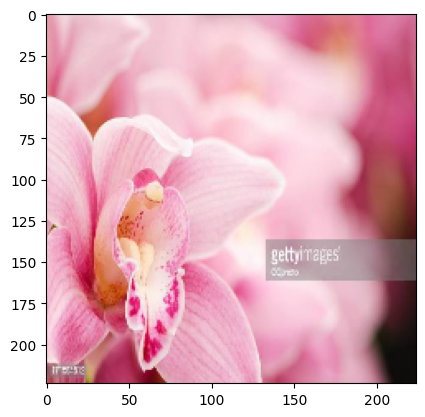

In [ ]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
train_df, val_df = train_test_split(df, stratify=df.label, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
class AttentionBlock(nn.Module):
  def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
    super(AttentionBlock, self).__init__()
    self.up_factor = up_factor
    self.normalize_attn = normalize_attn
    self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
    self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
    self.phi  = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)

  def forward(self, l,g):
    N, C, W, H = l.size()
    l_ = self.W_l(l)
    g_ = self.W_g(g)

    if self.up_factor > 1:
        g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
    c = self.phi(F.relu(l_ + g_))

    if self.normalize_attn:
      a = F.softmax(c.view(N, 1, -1), dim=2).view(N, 1, W, H)
    else:
      a = torch.sigmoid(c)

    f = torch.mul(a.expand_as(l), l)
    if self.normalize_attn:
      output = f.view(N, C, -1).sum(dim=2)
    else:
      output = F.adaptive_avg_pool2d(f, (1,1)).view(N, C)
    return a, output


In [ ]:
class AttnVGG(nn.Module):
  def __init__(self, num_classes, normalize_attn=False, dropout=None):
    super(AttnVGG, self).__init__()
    net = models.vgg16_bn(pretrained=True)
    self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
    self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
    self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
    self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
    self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
    self.pool = nn.AvgPool2d(7, stride=1)

    self.dpt = None
    if dropout is not None:
      self.dpt = nn.Dropout(dropout)
    self.cls = nn.Linear(in_features= 512+512+256, out_features=num_classes, bias=True)

    self.attn1 = AttentionBlock(256, 512, 256, 4,normalize_attn=normalize_attn)
    self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)

    self.reset_parameter(self.cls)
    self.reset_parameter(self.attn1)
    self.reset_parameter(self.attn2)

  def reset_parameter(self, module):
      for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0., 0.01)
            nn.init.constant_(m.bias, 0.)

  def forward(self, x):
      block1 = self.conv_block1(x)
      pool1= F.max_pool2d(block1, 2, 2)
      block2 = self.conv_block2(pool1)
      pool2 = F.max_pool2d(block2, 2, 2)
      block3 = self.conv_block3(pool2)
      pool3 = F.max_pool2d(block3, 2, 2)
      block4 = self.conv_block4(pool3)
      pool4 = F.max_pool2d(block4, 2, 2)
      block5 = self.conv_block5(pool4)
      pool5 = F.max_pool2d(block5, 2,2)
      N, __, __, __ = pool5.size()

      g = self.pool(pool5).view(N, 512)
      a1 , g1 = self.attn1(pool3, pool5)

      a2, g2 = self.attn2(pool4, pool5)

      g_hat = torch.cat((g, g1, g2), dim=1)

      if self.dpt is not None:
        g_hat = self.dpt(g_hat)

      out = self.cls(g_hat)

      return [out, a1, a2]


In [ ]:
model = AttnVGG(num_classes=5, normalize_attn=True)
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 84.6MB/s]


AttnVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def get_data():
  train = FlowerDataset(train_df)
  trn_dl = DataLoader(train, batch_size=16,shuffle=True, drop_last=True)
  val = FlowerDataset(val_df)
  val_dl = DataLoader(val, batch_size=16, shuffle=True, drop_last=True)
  return trn_dl, val_dl

In [ ]:
def train_batch(x, y, model,  loss_fn,opt):
  model.train()
  prediction, _, _ = model(x)
  prediction = torch.sigmoid(prediction.type(torch.FloatTensor).squeeze())
  batch_loss = loss_fn(prediction.to(device), y.to(device))
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  pred, _, _ = model(x)
  pred = torch.sigmoid(pred)
  _, is_correct = torch.max(pred.data,1)
  acc_all = (is_correct==y).detach().cpu().numpy()
  return acc_all

In [ ]:
@torch.no_grad()
def val_loss_trn(x, y, model, loss_fn):
  prediction, _, _ = model(x)
  prediction = torch.sigmoid(prediction)
  val_loss = loss_fn(prediction.to(device), y.to(device))
  return val_loss.item()

In [ ]:
trn_ldr, test_ldr = get_data()
print(device)

cuda


In [ ]:
import time
from tqdm import tqdm
start_time = time.time()

train_loss = []
train_accuracies= []
val_loss = []
val_accuracies = []

for i in range(25):
  print(f'Epoch: _________*****{i}*****_______')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies, val_epoch_losses = [], []



  for ix, batch in tqdm((enumerate(iter(trn_ldr))), total=len(trn_ldr)):
      x, y = batch
      train_epoch_losses.append(train_batch(x, y, model, loss_fn, optimizer))
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Training Loss : {train_epoch_loss} *****_______')



  for ix, batch in tqdm((enumerate(iter(trn_ldr))), total=len(trn_ldr)):
    x, y = batch
    train_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  train_epoch_accuracy = np.array(train_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Training Accuracy: {train_epoch_accuracy} *****_______')



  for ix, batch in tqdm((enumerate(iter(test_ldr))), total=len(test_ldr)):
    x, y = batch
    val_epoch_losses.append(val_loss_trn(x, y, model, loss_fn))
  val_epoch_loss = np.array(val_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Validation Loss : {val_epoch_loss} *****_______')

  for ix, batch in tqdm((enumerate(iter(test_ldr))), total=len(test_ldr)):
    x, y = batch
    val_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  val_epoch_accuracy = np.array(val_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Validation Accuracy. {val_epoch_accuracy} *****_______')
  print('\n')

  train_loss.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  val_loss.append(val_epoch_loss)

Epoch: _________*****0*****_______


100%|██████████| 234/234 [01:53<00:00,  2.06it/s]


Epoch: _________*****0 Training Loss : 1.23388876976111 *****_______


100%|██████████| 234/234 [00:57<00:00,  4.10it/s]


Epoch: _________*****0 Training Accuracy: 0.9043803418803419 *****_______


100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Epoch: _________*****0 Validation Loss : 1.0578409952995105 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch: _________*****0 Validation Accuracy. 0.8725961538461539 *****_______


Epoch: _________*****1*****_______


100%|██████████| 234/234 [01:38<00:00,  2.38it/s]


Epoch: _________*****1 Training Loss : 1.0197728956357026 *****_______


100%|██████████| 234/234 [00:57<00:00,  4.08it/s]


Epoch: _________*****1 Training Accuracy: 0.9091880341880342 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


Epoch: _________*****1 Validation Loss : 1.0535896703218803 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch: _________*****1 Validation Accuracy. 0.8701923076923077 *****_______


Epoch: _________*****2*****_______


100%|██████████| 234/234 [01:37<00:00,  2.39it/s]


Epoch: _________*****2 Training Loss : 0.984060801501967 *****_______


100%|██████████| 234/234 [00:57<00:00,  4.10it/s]


Epoch: _________*****2 Training Accuracy: 0.9561965811965812 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Epoch: _________*****2 Validation Loss : 0.9979164928962023 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch: _________*****2 Validation Accuracy. 0.9174679487179487 *****_______


Epoch: _________*****3*****_______


100%|██████████| 234/234 [01:39<00:00,  2.36it/s]


Epoch: _________*****3 Training Loss : 0.9595619778857272 *****_______


100%|██████████| 234/234 [00:57<00:00,  4.09it/s]


Epoch: _________*****3 Training Accuracy: 0.9778311965811965 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch: _________*****3 Validation Loss : 0.988211806003864 *****_______


100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Epoch: _________*****3 Validation Accuracy. 0.9262820512820513 *****_______


Epoch: _________*****4*****_______


100%|██████████| 234/234 [01:38<00:00,  2.38it/s]


Epoch: _________*****4 Training Loss : 0.9448625292533483 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.12it/s]


Epoch: _________*****4 Training Accuracy: 0.9805021367521367 *****_______


100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Epoch: _________*****4 Validation Loss : 0.9756630796652573 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch: _________*****4 Validation Accuracy. 0.936698717948718 *****_______


Epoch: _________*****5*****_______


100%|██████████| 234/234 [01:38<00:00,  2.37it/s]


Epoch: _________*****5 Training Loss : 0.9341661471586961 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.17it/s]


Epoch: _________*****5 Training Accuracy: 0.9775641025641025 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Epoch: _________*****5 Validation Loss : 0.9770056292032584 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch: _________*****5 Validation Accuracy. 0.9278846153846154 *****_______


Epoch: _________*****6*****_______


100%|██████████| 234/234 [01:37<00:00,  2.40it/s]


Epoch: _________*****6 Training Loss : 0.9341265780803485 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.17it/s]


Epoch: _________*****6 Training Accuracy: 0.9925213675213675 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


Epoch: _________*****6 Validation Loss : 0.9607994510577276 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Epoch: _________*****6 Validation Accuracy. 0.9463141025641025 *****_______


Epoch: _________*****7*****_______


100%|██████████| 234/234 [01:38<00:00,  2.38it/s]


Epoch: _________*****7 Training Loss : 0.9196349606554732 *****_______


100%|██████████| 234/234 [00:57<00:00,  4.06it/s]


Epoch: _________*****7 Training Accuracy: 0.9946581196581197 *****_______


100%|██████████| 78/78 [00:19<00:00,  3.97it/s]


Epoch: _________*****7 Validation Loss : 0.9620274511667398 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch: _________*****7 Validation Accuracy. 0.938301282051282 *****_______


Epoch: _________*****8*****_______


100%|██████████| 234/234 [01:39<00:00,  2.36it/s]


Epoch: _________*****8 Training Loss : 0.9269290255685138 *****_______


100%|██████████| 234/234 [00:57<00:00,  4.09it/s]


Epoch: _________*****8 Training Accuracy: 0.9882478632478633 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch: _________*****8 Validation Loss : 0.968462681158995 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Epoch: _________*****8 Validation Accuracy. 0.9350961538461539 *****_______


Epoch: _________*****9*****_______


100%|██████████| 234/234 [01:38<00:00,  2.38it/s]


Epoch: _________*****9 Training Loss : 0.9313736017952617 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.14it/s]


Epoch: _________*****9 Training Accuracy: 0.9516559829059829 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch: _________*****9 Validation Loss : 1.0194178682107191 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch: _________*****9 Validation Accuracy. 0.8782051282051282 *****_______


Epoch: _________*****10*****_______


100%|██████████| 234/234 [01:37<00:00,  2.39it/s]


Epoch: _________*****10 Training Loss : 0.9367178961252555 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.15it/s]


Epoch: _________*****10 Training Accuracy: 0.9938568376068376 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Epoch: _________*****10 Validation Loss : 0.9570689812684671 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch: _________*****10 Validation Accuracy. 0.9487179487179487 *****_______


Epoch: _________*****11*****_______


100%|██████████| 234/234 [01:38<00:00,  2.37it/s]


Epoch: _________*****11 Training Loss : 0.9318648673530318 *****_______


100%|██████████| 234/234 [00:57<00:00,  4.10it/s]


Epoch: _________*****11 Training Accuracy: 0.9898504273504274 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


Epoch: _________*****11 Validation Loss : 0.962966202161251 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.02it/s]


Epoch: _________*****11 Validation Accuracy. 0.9415064102564102 *****_______


Epoch: _________*****12*****_______


100%|██████████| 234/234 [01:37<00:00,  2.39it/s]


Epoch: _________*****12 Training Loss : 0.9239005665493827 *****_______


100%|██████████| 234/234 [00:55<00:00,  4.21it/s]


Epoch: _________*****12 Training Accuracy: 0.9933226495726496 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Epoch: _________*****12 Validation Loss : 0.9628847990280542 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch: _________*****12 Validation Accuracy. 0.9399038461538461 *****_______


Epoch: _________*****13*****_______


100%|██████████| 234/234 [01:38<00:00,  2.37it/s]


Epoch: _________*****13 Training Loss : 0.9274773883004473 *****_______


100%|██████████| 234/234 [00:57<00:00,  4.06it/s]


Epoch: _________*****13 Training Accuracy: 0.9906517094017094 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch: _________*****13 Validation Loss : 0.9695142790293082 *****_______


100%|██████████| 78/78 [00:19<00:00,  3.98it/s]


Epoch: _________*****13 Validation Accuracy. 0.9342948717948718 *****_______


Epoch: _________*****14*****_______


100%|██████████| 234/234 [01:38<00:00,  2.38it/s]


Epoch: _________*****14 Training Loss : 0.9349748846302685 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.14it/s]


Epoch: _________*****14 Training Accuracy: 0.9946581196581197 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Epoch: _________*****14 Validation Loss : 0.9659531544416379 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


Epoch: _________*****14 Validation Accuracy. 0.9423076923076923 *****_______


Epoch: _________*****15*****_______


100%|██████████| 234/234 [01:38<00:00,  2.39it/s]


Epoch: _________*****15 Training Loss : 0.9163944731410752 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.17it/s]


Epoch: _________*****15 Training Accuracy: 0.9933226495726496 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.01it/s]


Epoch: _________*****15 Validation Loss : 0.964320895763544 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch: _________*****15 Validation Accuracy. 0.9391025641025641 *****_______


Epoch: _________*****16*****_______


100%|██████████| 234/234 [01:37<00:00,  2.40it/s]


Epoch: _________*****16 Training Loss : 0.9157904343217866 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.16it/s]


Epoch: _________*****16 Training Accuracy: 0.9951923076923077 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch: _________*****16 Validation Loss : 0.963330647120109 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch: _________*****16 Validation Accuracy. 0.9439102564102564 *****_______


Epoch: _________*****17*****_______


100%|██████████| 234/234 [01:37<00:00,  2.40it/s]


Epoch: _________*****17 Training Loss : 0.9249752395682864 *****_______


100%|██████████| 234/234 [00:55<00:00,  4.19it/s]


Epoch: _________*****17 Training Accuracy: 0.9805021367521367 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch: _________*****17 Validation Loss : 0.9803481858510238 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch: _________*****17 Validation Accuracy. 0.9262820512820513 *****_______


Epoch: _________*****18*****_______


100%|██████████| 234/234 [01:37<00:00,  2.40it/s]


Epoch: _________*****18 Training Loss : 0.9166613284848694 *****_______


100%|██████████| 234/234 [00:55<00:00,  4.23it/s]


Epoch: _________*****18 Training Accuracy: 0.9941239316239316 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Epoch: _________*****18 Validation Loss : 0.9584115537313315 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


Epoch: _________*****18 Validation Accuracy. 0.9455128205128205 *****_______


Epoch: _________*****19*****_______


100%|██████████| 234/234 [01:37<00:00,  2.41it/s]


Epoch: _________*****19 Training Loss : 0.9120301782575428 *****_______


100%|██████████| 234/234 [00:55<00:00,  4.18it/s]


Epoch: _________*****19 Training Accuracy: 0.9962606837606838 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


Epoch: _________*****19 Validation Loss : 0.9547066978919201 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


Epoch: _________*****19 Validation Accuracy. 0.9455128205128205 *****_______


Epoch: _________*****20*****_______


100%|██████████| 234/234 [01:36<00:00,  2.42it/s]


Epoch: _________*****20 Training Loss : 0.9158616825046703 *****_______


100%|██████████| 234/234 [00:55<00:00,  4.21it/s]


Epoch: _________*****20 Training Accuracy: 0.9959935897435898 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


Epoch: _________*****20 Validation Loss : 0.9520627229641645 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Epoch: _________*****20 Validation Accuracy. 0.9527243589743589 *****_______


Epoch: _________*****21*****_______


100%|██████████| 234/234 [01:36<00:00,  2.41it/s]


Epoch: _________*****21 Training Loss : 0.9236811743332789 *****_______


100%|██████████| 234/234 [00:55<00:00,  4.19it/s]


Epoch: _________*****21 Training Accuracy: 0.9871794871794872 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


Epoch: _________*****21 Validation Loss : 0.9822239065781618 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch: _________*****21 Validation Accuracy. 0.9222756410256411 *****_______


Epoch: _________*****22*****_______


100%|██████████| 234/234 [01:36<00:00,  2.41it/s]


Epoch: _________*****22 Training Loss : 0.9273591128169981 *****_______


100%|██████████| 234/234 [00:55<00:00,  4.23it/s]


Epoch: _________*****22 Training Accuracy: 0.9834401709401709 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch: _________*****22 Validation Loss : 0.975050586156356 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


Epoch: _________*****22 Validation Accuracy. 0.9270833333333334 *****_______


Epoch: _________*****23*****_______


100%|██████████| 234/234 [01:37<00:00,  2.39it/s]


Epoch: _________*****23 Training Loss : 0.9286841803636307 *****_______


100%|██████████| 234/234 [00:55<00:00,  4.18it/s]


Epoch: _________*****23 Training Accuracy: 0.9903846153846154 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch: _________*****23 Validation Loss : 0.969684647443967 *****_______


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch: _________*****23 Validation Accuracy. 0.9326923076923077 *****_______


Epoch: _________*****24*****_______


100%|██████████| 234/234 [01:37<00:00,  2.39it/s]


Epoch: _________*****24 Training Loss : 0.9425251771751632 *****_______


100%|██████████| 234/234 [00:56<00:00,  4.14it/s]


Epoch: _________*****24 Training Accuracy: 0.9917200854700855 *****_______


100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


Epoch: _________*****24 Validation Loss : 0.9726299016903608 *****_______


100%|██████████| 78/78 [00:19<00:00,  3.98it/s]

Epoch: _________*****24 Validation Accuracy. 0.9334935897435898 *****_______




<ipython-input-36-69a12812d0cb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


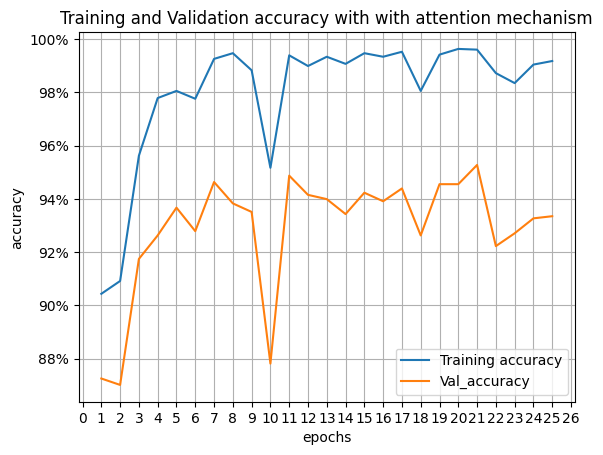

In [ ]:
epochs = np.arange(25) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_accuracies , label='Training accuracy')
plt.plot(epochs, val_accuracies, label='Val_accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation accuracy with with attention mechanism')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()

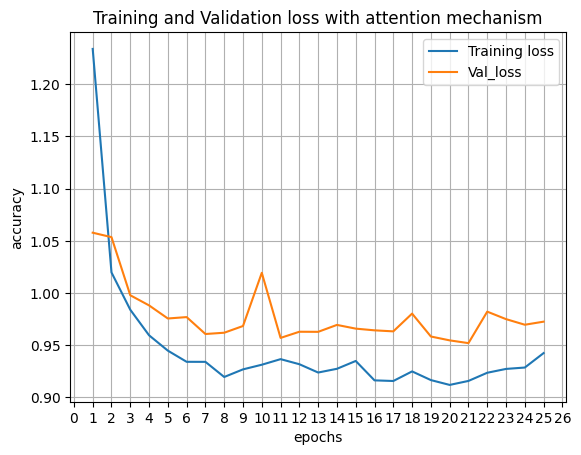

In [ ]:
epochs = np.arange(25) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_loss , label='Training loss')
plt.plot(epochs, val_loss, label='Val_loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation loss with attention mechanism')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in plt.gca().get_yticks()])/
plt.grid('off')
plt.show()